# Diabetes ML Model

In our exploratory analysis and ML models, we segmented the data by year. (See 'Diabetes_2011_EDA_ML.ipynb' and 'Diabetes_2015_EDA_ML.ipynb')  Our results indicated that feature importances were similar across both years.  In this final model, we dropped year from our data set and we analyze all data.

We also learned that BMI is an important factor, and since it is calculated from height and weight, we will remove those features from
the data set.

Finally, we saw that state was consistently an important feature, but since we believe that is not likely to be a causal relationship,
we removed it and found that the models still worked quite well.  

We will apply those lessons here and attemnpt to continue to refine.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from config import db_password 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from collections import Counter


In [2]:
# Connect to diabetes RDS database
# Define connection
DATABASES = {
    'production':{
        'NAME': 'Diabetes_db',
        'USER': 'postgres',
        'PASSWORD': db_password,
        'HOST': 'diabetesdb.cwyccvgtauvd.us-east-2.rds.amazonaws.com',
        'PORT': 5432,
    },
}

# Choose the database
db = DATABASES['production']

# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)

# read a table from database into pandas dataframe, replace "tablename" with your table name
df = pd.read_sql_table('diabetes',engine)
df.shape

(945188, 52)

# Data Prep

In [21]:
# Review nulls, sorted in descending order
nulls = df.isnull().sum().sort_values(ascending=False)
nulls

ADANXEV     910406
MISTMNT     910394
ADMOVE      910376
ADTHINK     910358
ADFAIL      910341
ADEAT1      910328
ADENERGY    910314
ADSLEEP     910306
ADDOWN      910293
ADPLEASR    910267
SCNTMONY    837087
SCNTMEAL    831481
ASTHNOW     820948
SMOKDAY2    529325
AVEDRNK2    493051
POORHLTH    455451
TOLDHI2     129077
_VEGESUM     70777
_BMI5        63609
_FRUTSUM     62243
EXERANY2     55993
WTKG3        52068
HTM4         22231
USENOW3      14832
SMOKE100     14195
RENTHOM1      2240
EMPLOY         443
EDUCA          349
MARITAL        218
RACE2          126
ADDEPEV2        10
BPHIGH4          6
GENHLTH          4
CHCKIDNY         3
CHCCOPD          2
HAVARTH3         2
MEDCOST          1
CHECKUP1         1
CVDINFR4         1
CVDCRHD4         1
PHYSHLTH         1
MENTHLTH         0
IYEAR            0
_AGE_G           0
_STATE           0
HLTHPLN1         0
PERSDOC2         0
CVDSTRK3         0
ASTHMA3          0
DIABETE3         0
SEX              0
index            0
dtype: int64

In [22]:
# create a list of columns where more than 800K of the rows (84% of the total data set) are null.  These columns should be removed
# from our further modeling

to_remove = nulls.loc[nulls > 800000].index.tolist()
to_remove

['ADANXEV',
 'MISTMNT',
 'ADMOVE',
 'ADTHINK',
 'ADFAIL',
 'ADEAT1',
 'ADENERGY',
 'ADSLEEP',
 'ADDOWN',
 'ADPLEASR',
 'SCNTMONY',
 'SCNTMEAL',
 'ASTHNOW']

In [23]:
# Drop the 'to_remove' columns
df = df.drop(columns=to_remove)
df.head()

,index,_STATE,IYEAR,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,...,USENOW3,AVEDRNK2,EXERANY2,RACE2,_AGE_G,HTM4,WTKG3,_BMI5,_FRUTSUM,_VEGESUM
0,0,1.0,2015,5.0,15.0,18.0,10.0,1.0,1.0,2.0,...,3.0,NaN,2.0,1.0,5.0,178.0,12701.0,4018.0,50.0,217.0
1,1,1.0,2015,3.0,88.0,88.0,NaN,2.0,1.0,1.0,...,3.0,NaN,1.0,1.0,4.0,173.0,7484.0,2509.0,24.0,78.0
2,2,1.0,2015,4.0,15.0,88.0,88.0,1.0,2.0,2.0,...,NaN,NaN,NaN,1.0,6.0,180.0,7167.0,2204.0,NaN,NaN
3,3,1.0,2015,5.0,30.0,30.0,30.0,1.0,2.0,1.0,...,3.0,NaN,2.0,1.0,5.0,170.0,8165.0,2819.0,100.0,20.0
4,4,1.0,2015,5.0,20.0,88.0,30.0,1.0,1.0,2.0,...,3.0,NaN,2.0,1.0,5.0,163.0,6441.0,2437.0,NaN,200.0


In [24]:
# Remove remaining NaN Values from all other fields (Features); replace with 0
df.fillna(0, inplace=True)

# Prepare data for Machine Learning

In [25]:
# split the data into X (features) and y (target)
# Drop ID because it is unique to each row
# Drop _STATE because it is not causal, and prelim analysis (Diabetes_2015_EDA_ML.ipynb)showed that model worked well without it
# Drop IYEAR because it is an identifier with no potential relationship to the outcome of diabetes
# Drop HTMW4 (height in meters) and WTKG3 (weight in kg) because we are utilizing the field BMI as a better input feature.

y = df['DIABETE3']
X = df.drop(columns=['DIABETE3','index','_STATE','IYEAR','HTM4','WTKG3'])
X.describe()

,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,TOLDHI2,...,SMOKE100,SMOKDAY2,USENOW3,AVEDRNK2,EXERANY2,RACE2,_AGE_G,_BMI5,_FRUTSUM,_VEGESUM
count,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,...,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000
mean,2.591885,60.631070,64.399970,29.051670,1.119785,1.391746,1.900829,1.601463,2.214817,1.400052,...,1.562439,1.057635,2.919640,1.600158,1.228367,1.976941,4.422571,2596.430179,131.644213,177.042252
std,1.136722,37.041381,35.926294,39.149821,0.504575,0.817551,0.426445,1.266273,1.031220,0.876470,...,0.703779,1.331982,0.547681,7.051702,0.733110,2.223922,1.526921,927.011165,135.395810,150.521746
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,15.000000,25.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,1.000000,1.000000,3.000000,2289.000000,43.000000,89.000000
50%,3.000000,88.000000,88.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,...,2.000000,0.000000,3.000000,0.000000,1.000000,1.000000,5.000000,2645.000000,100.000000,157.000000
75%,3.000000,88.000000,88.000000,88.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,...,2.000000,3.000000,3.000000,2.000000,2.000000,1.000000,6.000000,3034.000000,200.000000,233.000000
max,9.000000,99.000000,99.000000,99.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,99.000000,9.000000,9.000000,6.000000,9995.000000,15000.000000,20460.000000


In [26]:
# check balance of target column
y.value_counts()

0.0    809602
1.0    119717
4.0     15869
Name: DIABETE3, dtype: int64

In [27]:
# Transform y values to 0 = no diabetes; 1 = yes, diabetes.  Per BRFSS codebook 4 = prediabetes and we consider this as 'yes, diabetes'

y = y.replace({4:1})
y.value_counts()

0.0    809602
1.0    135586
Name: DIABETE3, dtype: int64

In [28]:
# Split into training and testing data sets
# Remove test size paramenter
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({0.0: 607302, 1.0: 101589})

In [29]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [30]:
# Create and fit RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=128)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=128)

In [31]:
# Make predictions
predictions = rfc.predict(X_test_scaled)

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(acc_score)

0.8638916279089451


In [32]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[198250   4050]
 [ 28112   5885]]
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.92    202300
         1.0       0.59      0.17      0.27     33997

    accuracy                           0.86    236297
   macro avg       0.73      0.58      0.60    236297
weighted avg       0.84      0.86      0.83    236297



In [33]:
# Calculate Feature importances
rfc.feature_importances_

array([0.05791545, 0.03909346, 0.0320097 , 0.03372427, 0.00688319,
       0.01631585, 0.0097523 , 0.01667106, 0.04333346, 0.02508912,
       0.01124839, 0.01265409, 0.00875039, 0.01286167, 0.01087189,
       0.01891219, 0.01395701, 0.00922745, 0.01491142, 0.03475504,
       0.03901535, 0.0188952 , 0.03920684, 0.01416764, 0.02120791,
       0.00634912, 0.02796106, 0.0204417 , 0.02357162, 0.0349936 ,
       0.14041573, 0.08308495, 0.10175188])

In [34]:
# Based on above importances, reduce the Features to the top 10 most imporantant

index_values = X.columns.to_list()
column_values = ["importance"]
importances = pd.DataFrame(data = rfc.feature_importances_, 
                  index = index_values, 
                  columns = column_values)

importances.sort_values('importance', ascending = False, inplace= True)

# Create a list of the importances after the top 20, which will be dropped from our X data:
cut = importances[10:]
to_cut = cut.index.to_list()

# Create new X data with only important columns

X = X.drop(columns=to_cut)
X.head()


,GENHLTH,PHYSHLTH,BPHIGH4,MARITAL,EDUCA,EMPLOY,_AGE_G,_BMI5,_FRUTSUM,_VEGESUM
0,5.0,15.0,1.0,1.0,4.0,8.0,5.0,4018.0,50.0,217.0
1,3.0,88.0,3.0,2.0,6.0,3.0,4.0,2509.0,24.0,78.0
2,4.0,15.0,3.0,2.0,4.0,7.0,6.0,2204.0,0.0,0.0
3,5.0,30.0,1.0,1.0,4.0,8.0,5.0,2819.0,100.0,20.0
4,5.0,20.0,3.0,1.0,5.0,8.0,5.0,2437.0,0.0,200.0


In [35]:
# Re-run model on top 10 Features

# Split into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({0.0: 606930, 1.0: 101961})

In [36]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
# Create and fit RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=128)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=128)

In [38]:
# Make predictions
predictions = rfc.predict(X_test_scaled)

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(acc_score)

0.8558635953905467


In [39]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[196134   6538]
 [ 27521   6104]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92    202672
         1.0       0.48      0.18      0.26     33625

    accuracy                           0.86    236297
   macro avg       0.68      0.57      0.59    236297
weighted avg       0.82      0.86      0.83    236297



In [40]:
# Calculate Feature importances
rfc.feature_importances_

array([0.06282931, 0.07014879, 0.05496672, 0.05139718, 0.05506498,
       0.04848305, 0.0381835 , 0.25389015, 0.1502463 , 0.21479002])

(<AxesSubplot:>,)

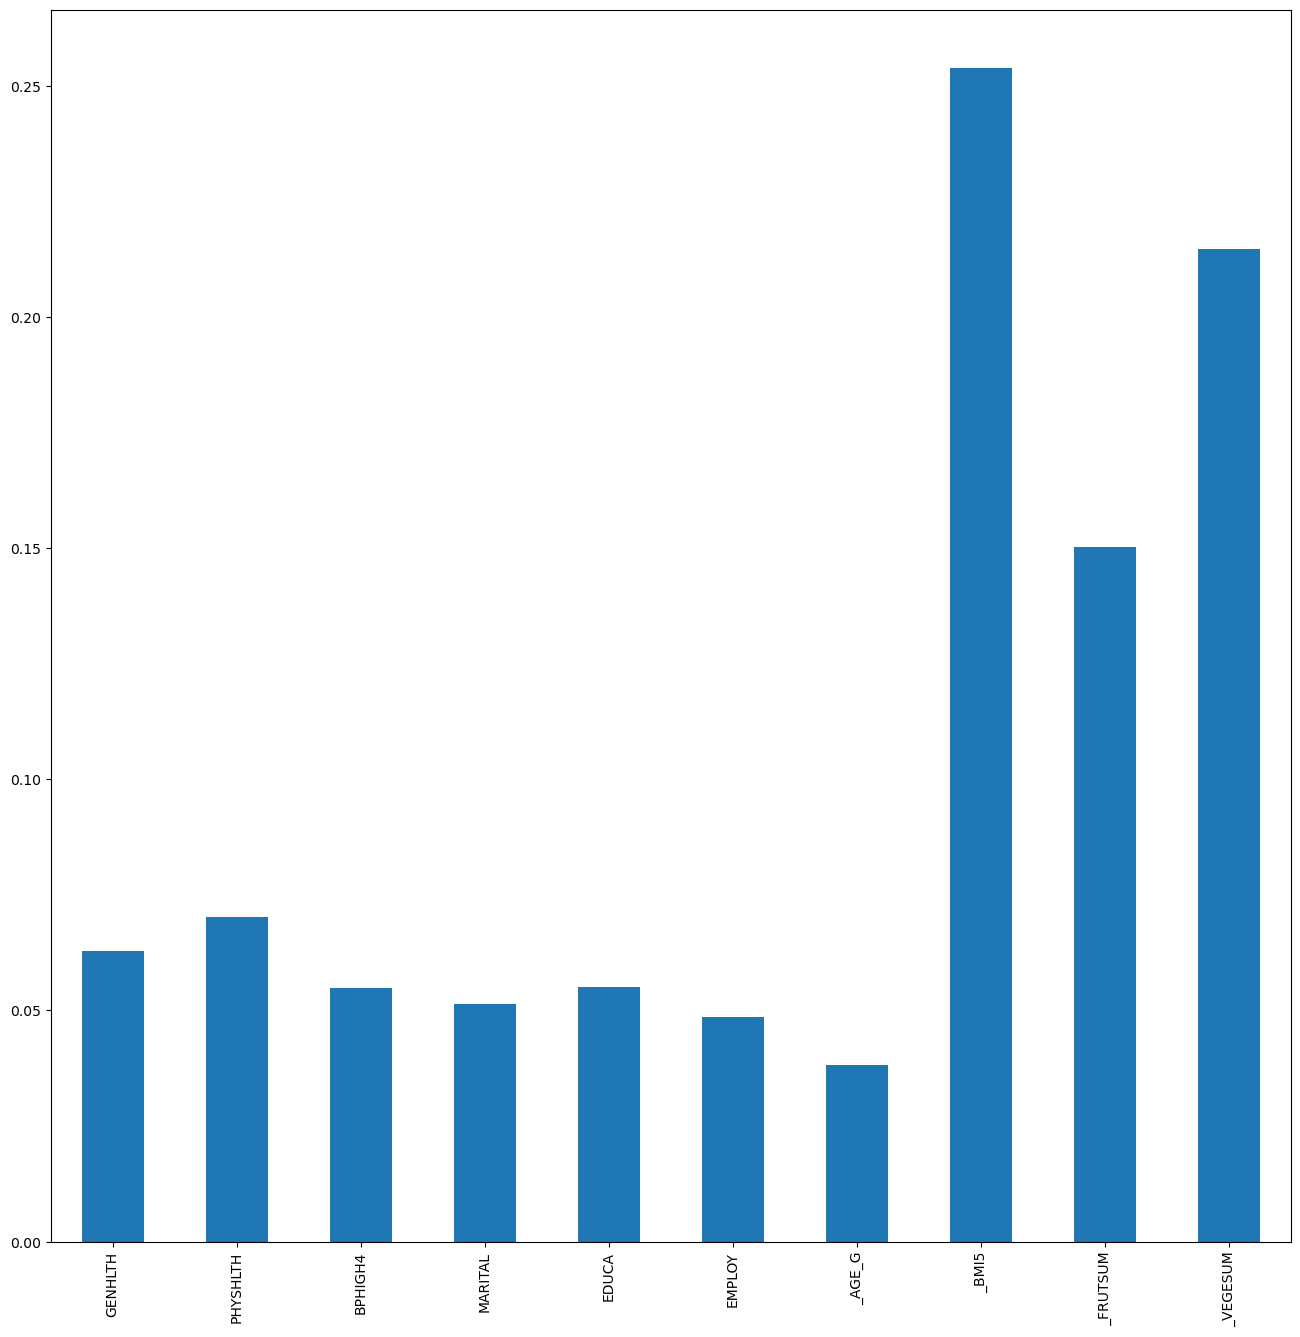

In [41]:
# Plot importances
(pd.Series(rfc.feature_importances_, index=X.columns,).plot(kind='bar', figsize=(16,16)), )

In [43]:
# Compare our ML model to ADA survey questions.abs
X=df[['_AGE_G','SEX','BPHIGH4','EXERANY2','RACE2','_BMI5']]
X.head()

,_AGE_G,SEX,BPHIGH4,EXERANY2,RACE2,_BMI5
0,5.0,2.0,1.0,2.0,1.0,4018.0
1,4.0,2.0,3.0,1.0,1.0,2509.0
2,6.0,2.0,3.0,0.0,1.0,2204.0
3,5.0,2.0,1.0,2.0,1.0,2819.0
4,5.0,2.0,3.0,2.0,1.0,2437.0


In [44]:
# Re-run model

# Split into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({1.0: 101798, 0.0: 607093})

In [45]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [46]:
# Create and fit RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=128)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=128)

In [47]:
# Make predictions
predictions = rfc.predict(X_test_scaled)

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(acc_score)

0.843201564133273


In [48]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[193974   8535]
 [ 28516   5272]]
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91    202509
         1.0       0.38      0.16      0.22     33788

    accuracy                           0.84    236297
   macro avg       0.63      0.56      0.57    236297
weighted avg       0.80      0.84      0.81    236297



In [49]:
rfc.feature_importances_

array([0.08685902, 0.00836554, 0.1481637 , 0.02202561, 0.05321595,
       0.68137018])

(<AxesSubplot:>,)

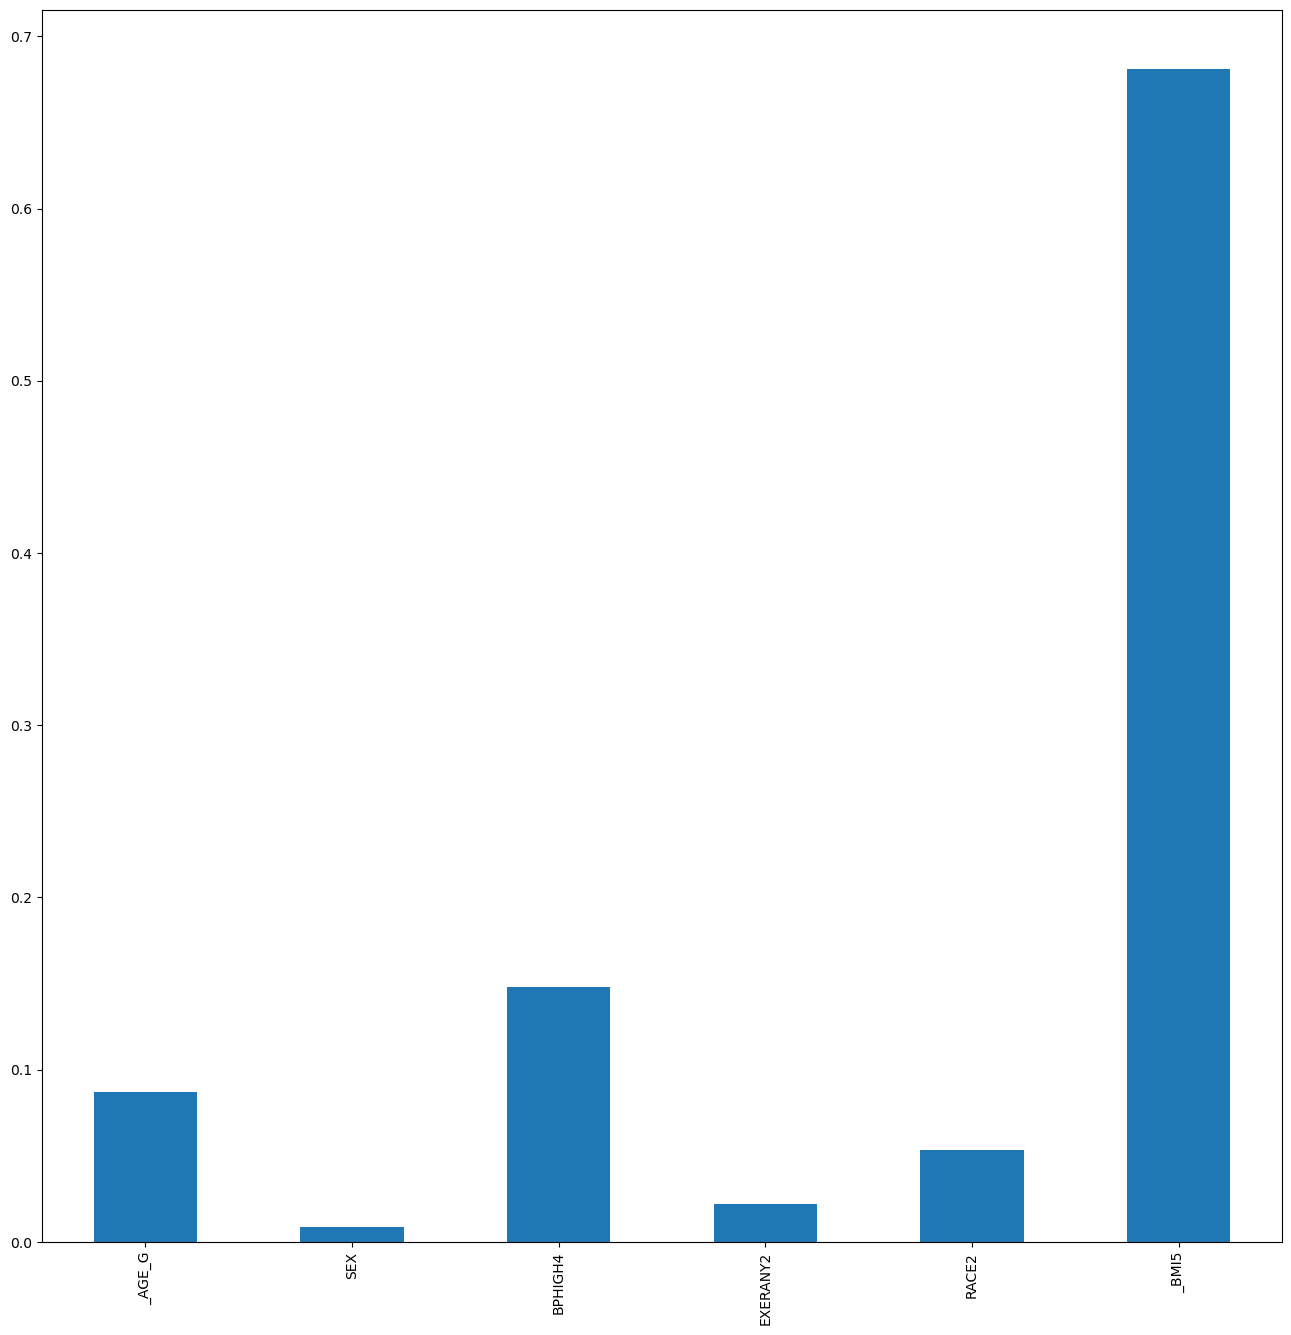

In [50]:
# Plot importances
(pd.Series(rfc.feature_importances_, index=X.columns,).plot(kind='bar', figsize=(16,16)), )